In [1]:
import requests as rq
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from pipeline import *

In [2]:
start_time = "2021-07-22 00:00:00"
end_time = "2021-07-29 00:00:00"
params = {
    'DataSet': 'SGWL.Working@OW283',
    'StartTime': start_time,
    'EndTime': end_time,
    'ExportFormat': 'csv',
    'Compressed': 'false',
    'RoundData': 'False',
    'Unit': '306',
    'Timezone': '-7', 
}

token = rq.post(url = f"https://aqrt.nrs.gov.bc.ca/Export/DataSetToken", params=params).json()["Token"]
params['Token'] = token.replace('+', '%2B').replace('/', r'%2F')
response = rq.get(url = f"https://aqrt.nrs.gov.bc.ca/Export/DataSet", params=params)
reader = list(csv.reader(response.text.splitlines()))

In [3]:
cleaned = np.transpose(tuple(filter(lambda x: x, map(lambda x: clean_and_process(x[0], x[1], x[3]), reader))))

In [4]:
with open("data/dataset.csv") as data:
    parsed = filter(lambda x: x, map(lambda x: clean_and_process(x[0], x[1], x[3]), csv.reader(data)))
    split = year_splitter(parsed)
    years = list(map(lambda x: np.transpose(unify_year(x)), split))

In [5]:
def rolling_mean(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

<ipython-input-24-add9d27d8515>:6: UserWarning: Attempting to set identical left == right == 18993.25 results in singular transformations; automatically expanding.
  ax.set_xlim(years[-2][0][-1], years[0][0][-1])


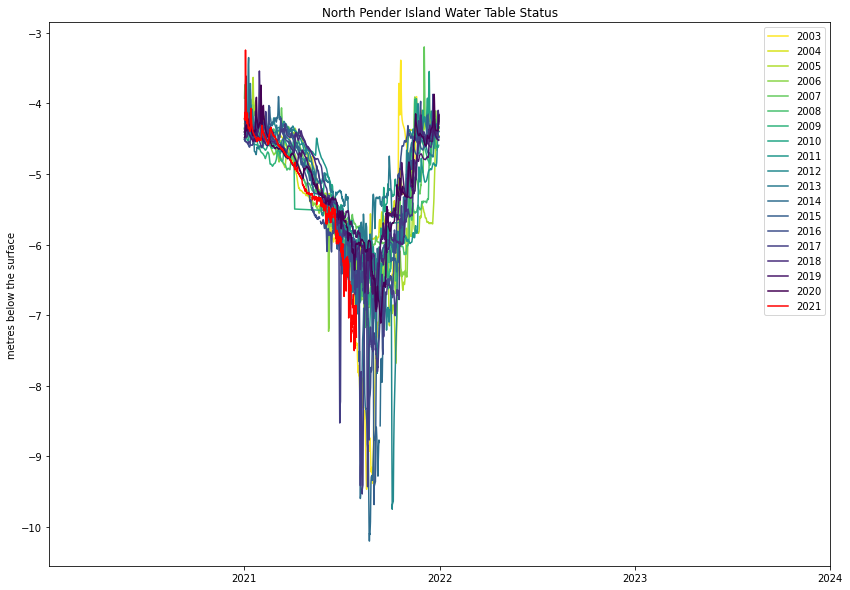

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)

ax.set_ylabel("metres below the surface")
ax.set_title("North Pender Island Water Table Status")
ax.set_xlim(years[-1][0][0], years[0][0][-1])

locator = mdates.AutoDateLocator(minticks=3, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

colourmap = cm.get_cmap('viridis')

year_plots = []

for i, year in enumerate(years[:-1]):
    year_as_percentage = i/(2020-2003)
    (year_plot, ) = ax.plot(year[0][:-40], rolling_mean(year[1], 40)[:-40], color=colourmap(1-year_as_percentage), label=i+2003)
    year_plots.append(year_plot)
ax.plot(years[-1][0], years[-1][1], color="red", label=2021)

ax.legend()

# Notes

The natural level, with enough rainfall and non-overwhelming water use, seems to be ~-4.4m. 
Spikes lasting a day or two appear, presumably from heavy rainfall, but quickly return to the resting level.
Beginning in roughly April-May, increased water usage, increased temperature, and decreased summer rainfall cause a slow decline until around July, at which point droughts begin, and water level plummets rapidly in some years (including 2021!)
The dry season lasts until September, and the autumn rains replenish the aquifers for the new year.
I believe sharp spikes to be artifacts of faulty data collection or instrument errors, as the aquifer simply cannot fall and rise 10 metres in the same day.
A combination of outlier clipping and 24-hr rolling averaging helps to smooth out the worst spikes, but introduces its own artifacts.
Namely, the nearly-perfect right-angle dip on April 1st, which is nonexistent without the convolution and increases in amplitude with a longer window.
The data also has gaps, which my filtering has not yet managed to completely eliminate. 
The longer the window, the longer the gaps become, but they are present even in raw data.
They should be marked by a status code of -3, but this undocumented API isn't perfect.
I've removed data from before 2003 as it was being measured by an unknown method, so the precision, accuracy, and resolution are significantly worse than the automated, solar-satellite depth sensor installed today.